# Table of Contents
1. [Introduction](#1-introduction)
2. [Reading data](#2-reading-data)
    - 2.1 [File Structure](#21-file-structure)
    - 2.2 [Raw Data](#22-raw-data)
3. [Integrate Data](#3-integrate-data)
    - 3.1 [Determine Degree of Symmetry](#31-determine-degree-of-symmetry-azimuthalpolar-integration)
    - 3.2 [Radial integration](#32-radial-integration)
    - 3.3 [Reshape](#33-reshape)
        - 3.3.1 [Plot Intensity on sample geometry](#331-plotting-intensity-on-sample-geometry-all-images)
4. [Curve Fitting](#4-curve-fitting)
    - 4.1 [Removing Background Noise](#41-removing-background-noise)
    - 4.1.1 [Plot Data Without Background Noise](#42-plot-data-without-background-noise)
    - 4.2 [Fit Noise Free Data To Some Function](#43-fit-nosie-free-data-to-some-function)
    - 4.3 [Plot Fitted Data](#44-plot-fitted-data)

# 1 Introduction
Some information about SAXS/WAXS and the experiments.

# 2 Reading data


## 2.1 File structure
The data we have at FORMAX is gathered by two sensors.

    lambda, which measures the Wide Angle X-ray Scattering (WAXS)
    eiger, which measures the Small Angle X-ray Scattering (SAXS)

The sensors measure the number of photon hitting each pixel for a given exposure time, This is the raw data.

For each scan, there are three files that are stored as HDF5 files in the raw/ folder, which houses this data:

    scan-xxxx.h5: The master file for the scan, containing useful metadata for the scan.
    scan-xxxx_lambda.h5: The data from the WAXS scan.
    scan-xxxx_eiger.h5: The data from the SAXS scan.

Let us load the data first. We will also create a function that gives us the appropriate file path to use. 

In [52]:
import h5py
import os
import hdf5plugin
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors

In [58]:
import os

def get_file_path(scan_nr: int, scattering_method: str, raw=False):
    """
    Retrieve the file path to the specified sample.

    Parameters
    ----------
    scan_nr : int
        The scan number identifying the specific sample.
    scattering_method : str
        Scattering method used (SAXS or WAXS).
    raw : bool, optional
        If True, returns the path to the raw data file with intensity I(x,y) in Cartesian coordinates.
        If False, returns the path to the pre-processed file with intensity I(azimuthal_angle, q) in polar coordinates.

    Returns
    -------
    file_path : str
        The file path to the specified sample.
    """
    # Detector mapping from scattering method to detector name in filenames
    detector_mapping = {
        'SAXS': 'eiger',
        'WAXS': 'lambda'
    }

    # Convert the input to uppercase for case-insensitive matching
    scattering_method_upper = scattering_method.upper()

    if scattering_method_upper in detector_mapping:
        detector_type = detector_mapping[scattering_method_upper]
    else:
        raise ValueError("Invalid scattering method. Must be 'SAXS' or 'WAXS'.")

    # Zero-pad the scan number to 4 digits
    scan_str = f"{scan_nr:04d}"  # E.g., 35 becomes '0035'

    # Get the absolute path to the data directory
    # Assuming the script is in the 'MVE386' directory
    script_dir = os.path.dirname(os.path.abspath(''))
    data_directory = os.path.join(script_dir, 'data')

    # Construct the filename
    if raw:
        filename = f'scan-{scan_str}_{detector_type}.h5'
    else:
        filename = f'scan-{scan_str}_{detector_type}_integrated.h5'

    # Construct the full file path
    file_path = os.path.join(data_directory, filename)

    return file_path

# Example
scan_number = 35
scattering_method = 'WAXS'
raw = True 

example_file_path = get_file_path(scan_number, scattering_method, raw)
print(f"Constructed file path: {example_file_path}")


Constructed file path: c:\Users\alfre\OneDrive\Skrivbord\MVE368\GitHub\MVE386\data\scan-0035_lambda.h5


## 2.2 Raw Data
Let us visualize the raw data for a SAXS and WAXS sample to get some idea of what we are working with.

We begin by loading the raw data versions of one SAXS and one WAXS sample to examine them. The SAXS data is rather straightforward, simply extract the data from 'scan-0035_eiger.h5/entry/instrument/eiger/data'. For the WAXS data, due to the experimental setup, the data is divided in 4 parts--one for each detector. The detectors are setup in a "windmill shape" where each detector is oriented at 90 degree angles from eachother--we need to restructure the data so that it reflects the geometry of the sample.

In [59]:
def extract_raw_SAXS_data(filepath: str, image_number: int):
    """
    Extracts the raw data from an Eiger (SAXS) detector HDF5 file for a specified image.

    Parameters
    ----------
    filepath : str
        Path to the HDF5 file containing the raw Eiger detector data.
    image_number : int
        Index of the image to extract from the dataset.

    Returns
    -------
    data : numpy.ndarray
        The extracted raw data array for the specified image, with invalid values set to NaN.

    Notes
    -----
    - Values above 1e9 are considered invalid and are set to NaN.
    """
    with h5py.File(filepath, 'r') as fh:
        data = fh['/entry/instrument/eiger/data'][image_number, :, :].astype(np.float32)

    # Set values above 1e9 to NaN
    data[data > 1e9] = np.nan

    return data

def extract_raw_WAXS_data(filepath: str, image_number: int):
    """
    Extracts and reconstructs the raw data from a Lambda (WAXS) detector HDF5 file for a specified image.

    The Lambda detector consists of four modules arranged in a windmill shape. This function reconstructs
    the full image by rotating and placing each module's data into the correct position.

    Parameters
    ----------
    filepath : str
        Path to the HDF5 file containing the raw Lambda detector data.
    image_number : int
        Index of the image to extract from the dataset.

    Returns
    -------
    full_data : numpy.ndarray
        The reconstructed full data array for the specified image.
    """
    with h5py.File(filepath, 'r') as fh:
        # Read necessary metadata and data
        full_shape = fh['/entry/instrument/lambda/full_shape'][()]
        rotation = fh['/entry/instrument/lambda/rotation'][()]
        x_positions = fh['/entry/instrument/lambda/x'][()]
        y_positions = fh['/entry/instrument/lambda/y'][()]
        data = fh['/entry/instrument/lambda/data'][image_number, :, :, :]

    # Initialize the full data array with NaNs
    full_data = np.full(full_shape, np.nan, dtype=np.float32)

    # Reconstruct the full image from the four modules
    for i in range(4):
        # Rotate each module's data
        rotation_steps = int(-rotation[i] / 90)  # Convert rotation angle to steps for np.rot90
        rotated_data = np.rot90(data[i, :, :], k=rotation_steps)
        # Determine the position to insert the rotated data
        x_start = x_positions[i]
        y_start = y_positions[i]
        x_end = x_start + rotated_data.shape[1]
        y_end = y_start + rotated_data.shape[0]
        # Insert the rotated data into the full image
        full_data[y_start:y_end, x_start:x_end] = rotated_data

    return full_data

# Set up file paths
scan_number = 35
SAXS_file_path = get_file_path(scan_number, 'SAXS', raw=True)
WAXS_file_path = get_file_path(scan_number, 'WAXS', raw=True)

# Load data
image_number = 500
SAXS_data = extract_raw_SAXS_data(SAXS_file_path, image_number)
print(f'Read {os.path.basename(SAXS_file_path)} (image {image_number}) to: SAXS_data')
WAXS_data = extract_raw_WAXS_data(WAXS_file_path, image_number)
print(f'Read {os.path.basename(WAXS_file_path)} (image {image_number}) to: WAXS_data')

Read scan-0035_eiger.h5 (image 500) to: SAXS_data
Read scan-0035_lambda.h5 (image 500) to: WAXS_data


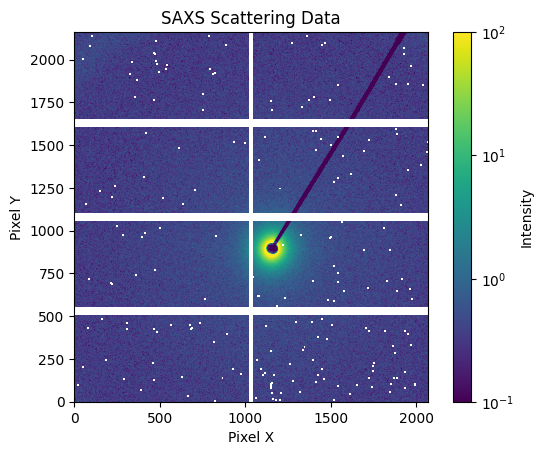

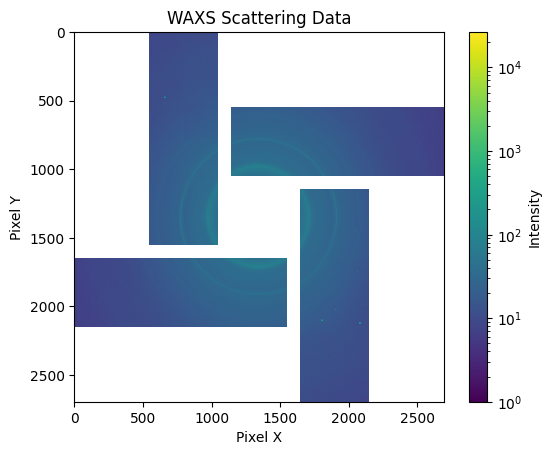

In [55]:
def plot_detector_data(data, scattering_method, ax=None):
    """
    Plots the detector data for either SAXS or WAXS scattering methods.

    Parameters
    ----------
    data : numpy.ndarray
        The data array to plot.
    scattering_method : str
        The scattering method used, either 'SAXS' or 'WAXS'.
    ax : matplotlib.axes.Axes, optional
        Matplotlib axes object on which to plot. If None, uses the current axes (`plt.gca()`).

    Returns
    -------
    im : matplotlib.image.AxesImage
        The image object created.

    Raises
    ------
    ValueError
        If an invalid `scattering_method` is provided.

    Notes
    -----
    - For 'SAXS' (Eiger detector), applies a symmetric logarithmic normalization.
    - For 'WAXS' (Lambda detector), applies a logarithmic normalization.
    - Automatically handles NaN values in the data.
    """
    if ax is None:
        ax = plt.gca()

    # Check for correct input
    scattering_method_upper = scattering_method.upper()
    if scattering_method_upper not in ['SAXS', 'WAXS']:
        raise ValueError("Invalid scattering_method. Must be 'SAXS' or 'WAXS'.")

    if scattering_method_upper == 'SAXS':
        # Plotting parameters for SAXS data
        norm = mcolors.SymLogNorm(linthresh=1e-3, vmin=1e-1, vmax=1e2)
        cmap = 'viridis'
        origin = 'lower'
        title = 'SAXS Scattering Data'
    elif scattering_method_upper == 'WAXS':
        # Plotting parameters for WAXS data
        norm = mcolors.LogNorm()
        cmap = 'viridis'
        origin = 'upper'  # Adjust if needed
        title = 'WAXS Scattering Data'
    else:
        raise ValueError("Invalid detector_type after mapping. This should not happen.")

    im = ax.imshow(
        data,
        norm=norm,
        cmap=cmap,
        origin=origin
    )
    ax.set_title(title)
    ax.set_xlabel('Pixel X')
    ax.set_ylabel('Pixel Y')
    plt.colorbar(im, ax=ax, label='Intensity')

    return im

fig, ax1 = plt.subplots()
plot_detector_data(SAXS_data, scattering_method='SAXS', ax=ax1)
plt.show()

fig, ax2 = plt.subplots()
plot_detector_data(WAXS_data, scattering_method='WAXS', ax=ax2)
plt.show()

# 3 Integrate Data
The data in this form is not directly useful for anything other than displaying the diffraction patterns, it needs to be processed for us to be able to continue the analysis. To understand the logic behind what is done with the data, let us go through some brief scattering theory.

The scattering behaviour of X-rays can be explained by Bragg's law
$
\begin{equation}
n\lambda = 2dsin(\theta),
\end{equation}
$
where $n$ is a positive integer, $\lambda$ the wavelength of X-rays, $d$ the so called repeating distance between structures in the sample and $2\theta$ the scattering angle. According to Bragg's law, intensity peaks in the diffraction pattern dirrectly correspond to a repeating unit in the material.

When studying diffraction patterns it is conventient to define a wave vector $\boldsymbol{q}$ as
$
\begin{equation}
\boldsymbol{q} = \boldsymbol{k}_0 - \boldsymbol{k}_1,
\end{equation}
$
where $\boldsymbol{k}_0$ is the primary wave vector of incoming X-rays that go through the sample without scattering and $\boldsymbol{k}_1$ the wave vector of scattered X-rays at an angle $2\theta$ from $\boldsymbol{k}_0$. When the primary wave is scattered elastically, the wavelength remain constant, thus the length of $\boldsymbol{k}_1$ must be equal to $\boldsymbol{k}_0$. The magnitude of $\boldsymbol{k}_0$ is determined by its wavelength number $|\boldsymbol{k}_0| = \frac{2\pi}{\lambda}$. We can then calculate the magnitude of the wave vector $\boldsymbol{q}$ (which is the radius from the center of our diffraction pattern) with the help of the law of cosines
$
\begin{equation}
|\boldsymbol{q}| = |\boldsymbol{k}_0 - \boldsymbol{k}_1| = \sqrt{ \boldsymbol{k}_0^2 + \boldsymbol{k}_1^2 - 2\boldsymbol{k}_0\boldsymbol{k}_1\text{cos}(2\theta) } = \sqrt{ 2(\frac{2\pi}{\lambda})^2 \cdot 2\text{sin}^2(\theta) } = \frac{4\pi\text{sin}(\theta)}{\lambda},
\end{equation}
$
where the Pythagorean identity $\text{sin}^2 + \text{cos}^2 = 1$ is used between the third equality.

By combining (1) and (3) we get a relationship between the repeating distance $d$ and $|\boldsymbol{q}|$ (referred to as $q$ from here on out)
$
\begin{equation}
d = \frac{2\pi}{q} \iff q = \frac{2\pi}{d},
\end{equation}
$
where $n = 1$ since we in this case only look at the first occurance of the intensity peak. We see that $q$ is inversely proportional to the repeating distance.

The important thing to draw from the above math excursion is that since we have a direct relationship between $d$ and $q$, it would be nice if we could express our intensity data $I$ in terms of $q$. Since $q$ is the radial component of the diffraction images, it makes sense to convert the original $I(x,y)$ which is in Cartesian coordinates to 2D-polar coordinates $I(q, \phi)$, where $\phi\in[0,2\pi]$ is the azimuthal angle of $q$ (0^{\circ}).

Luckily, this is done for us automatically for each scan at MAX IV. In addition to the conversion to polar coordinates, this data is also normalized for beam intensity fluctuations and corrected for polarization. The data is availible in the /process/azint/ folder with labels:

    scan-xxxx_lambda_integrated.h5: The transformed data from the WAXS scan.
    scan-xxxx_eiger_integrated.h5: The transformed data from the SAXS scan.


Let us now load the transformed data.

In [ ]:
def load_transformed_data(scan_number: int, scattering_method: str):
    """
    Load the azimuthally integrated data and return a dictionary with the relevant keys.

    Parameters
    ----------
    scan_number : int
        The scan number identifying the specific sample.
    scattering_method : str
        Scattering method used ('SAXS' or 'WAXS').

    Returns
    -------
    data : dict
        A dictionary containing the loaded data.

    Keys in the returned data dictionary:

    **From Integrated (Azimuthally Integrated) File**
    - 'I' : Cake plot from radial integration, shape (image, azimuthal angle, q)
    - 'azi' : Azimuthal bins (degrees)
    - 'q' : q-vector for integration (Å⁻¹)
    - 'mask_file' : File path for mask used in radial integration
    - 'norm' : Weights/norm sum for computing averages for integrated data
    - 'polarization_factor' : Polarization factor used for integration
    - 'poni_file' : File path for PONI file

    **From Raw (Master) File**
    - 'i_t' : Diode data, transmittance for 2D map
    - 'title' : Scan command from the instrument control software
    - 'shape' : Tuple indicating the shape of the scan (rows, columns)
    """
    # Map scattering_method to detector_type
    detector_mapping = {
        'SAXS': 'eiger',
        'WAXS': 'lambda'
    }

    scattering_method_upper = scattering_method.upper()
    if scattering_method_upper in detector_mapping:
        detector_type = detector_mapping[scattering_method_upper]
    else:
        raise ValueError("Invalid scattering method. Must be 'SAXS' or 'WAXS'.")

    # Get the file path to the integrated data file
    file_path = get_file_path(scan_number, scattering_method, raw=False)

    # Set up dictionary
    data = {}
    items = {
        'I': 'entry/data2d/cake',
        'q': 'entry/data1d/q',
        'azi': 'entry/data2d/azi',
        'mask_file': 'entry/azint/input/mask_file',
        'norm': 'entry/data2d/norm',
        'polarization_factor': 'entry/azint/input/polarization_factor',
        'poni_file': 'entry/azint/input/poni',
    }

    # Load data from the integrated (azimuthally integrated) file
    with h5py.File(file_path, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]
            else:
                print(f"Warning: {name} not found in integrated file.")

    # Construct the master file path by replacing '_integrated' in the filename
    master_file_path = file_path.replace(f'_{detector_type}_integrated.h5', f'.h5')
    master_items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',
        'title': 'entry/title',
    }

    # Load data from the master (raw) file
    if os.path.isfile(master_file_path):
        with h5py.File(master_file_path, 'r') as fh:
            for key, name in master_items.items():
                if name in fh:
                    data[key] = fh[name][()]
                else:
                    print(f"Warning: {name} not found in master file.")
    else:
        print(f"Master file {master_file_path} not found.")

    # The command used has information on the snake scan performed, we use it.
    # Note: Tried to rewrite this but failed miserably, I will not touch it. 
    data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))

    return data

# Load the transformed data
scan_number = 35
SAXS_data = load_transformed_data(scan_number, 'SAXS')
WAXS_data = load_transformed_data(scan_number, 'WAXS')

# Access data
I_SAXS = SAXS_data.get('I')
azi_SAXS = SAXS_data.get('azi')
q_SAXS = SAXS_data.get('q')
shape_SAXS = SAXS_data.get('shape')

I_WAXS = WAXS_data.get('I')
azi_WAXS = WAXS_data.get('azi')
q_WAXS = WAXS_data.get('q')
shape_WAXS = WAXS_data.get('shape')

# Display information
print('SAXS data:')
print(f"The shape of the intensity function is {I_SAXS.shape} (number of images, azimuthal angles, q)")
print(f"There are {len(azi_SAXS)} azimuthal angle measurements, ranging from {azi_SAXS[0]} to {azi_SAXS[-1]} degrees.")
print(f"There are {len(q_SAXS)} q measurements, ranging from q = {q_SAXS[0]:.2e} to q = {q_SAXS[-1]:.2e} Å⁻¹.")
print(f"The scan consists of images for {shape_SAXS[0]} rows and {shape_SAXS[1]} columns.")
print('')
print('WAXS data:')
print(f"The shape of the intensity function is {I_WAXS.shape} (number of images, azimuthal angles, q)")
print(f"There are {len(azi_WAXS)} azimuthal angle measurements, ranging from {azi_WAXS[0]} to {azi_WAXS[-1]} degrees.")
print(f"There are {len(q_WAXS)} q measurements, ranging from q = {q_WAXS[0]:.2e} to q = {q_WAXS[-1]:.2e} Å⁻¹.")
print(f"The scan consists of images for {shape_WAXS[0]} rows and {shape_WAXS[1]} columns.")


SAXS data:
The shape of the intensity function is (3050, 180, 2000) (number of images, azimuthal angles, q)
There are 180 azimuthal angle measurements, ranging from 1.0 to 359.0 degrees.
There are 2000 q measurements, ranging from q = 2.15e-04 to q = 4.41e-01 Å⁻¹.
The scan consists of images for 61 rows and 50 columns.

WAXS data:
The shape of the intensity function is (3050, 180, 2000) (number of images, azimuthal angles, q)
There are 180 azimuthal angle measurements, ranging from 1.0 to 359.0 degrees.
There are 2000 q measurements, ranging from q = 3.85e-03 to q = 6.88e+00 Å⁻¹.
The scan consists of images for 61 rows and 50 columns.


## 3.1 Determine Degree of Symmetry (Azimuthal/Polar Integration)
For some q-range, take integrate through all azimuthal angles $\theta$, take the average over the q-range for each $\theta$ angle. Then compute if there is "large" differences between different $\theta$ directions.

If there is not, we can use all $\theta$ angles for radial integration (or any $\theta$?).

If there is differences, we later integrate radially in the interesting directions found.

## 3.2 Radial integration
Depending if we found that the sample was symmetrical or not, for specified $\theta$ range, integrate across all $q$-values. From this we get I vs q data.

## 3.3 Reshape
The Images are ordered by the snake scan, starting in the top left, image 1 corresponds to column coordinate (0, 0). To make the order of $I$ relate to the spatial position of the sample, every other row needs to be flipped.

### 3.3.1 Plotting intensity on sample geometry (all images)
After reshaping I to match the spatial position of the sample, we can use the average the azimuthal integrated data (for each image), average across all q, to get the average total intensity for each position of the sample.

# 4 Curve fitting

## 4.1 Removing background noise
Simply subtract the bottom row of the reshaped I data from all the other rows of I.

### 4.1.1 Plot data without background noise
I vs q and d

## 4.3 Fit nosie free data to some function
Fourier series, Taylor series, multi-Gaussian fitting 

## 4.4 Plot fitted data
I vs q and d